This notebook contains code for running basic time series analysis on the energy generated data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime   # package that helps manipulate dates

#for decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose

# used for autocorrelation
import statsmodels.api as sm


In [3]:
# increase figure size
plt.rcParams['figure.figsize'] = [14, 10]

In [4]:
#Importing data and cleaning to make a nice df with 2 columns

# import data (file and path are not from github, just downloaded because git stuff wasn't completed yet)
df = pd.read_csv("./nrg_gen_full_daily.csv")

#renaming the columns we want to actually keep 
df.rename(columns={
        'Data Dica': 'date', 
        'Selecione Tipo de GE Simp 4': 'energy_generated'
    }, inplace=True)

#Creating list of all columns we want to delete (gotten in separate cell using df.columns)
badcols = ['Data Escala de Tempo 1 GE Simp 4',
       'cod_aneel (tb_referenciacegusina (Usina))',
       'cod_nucleoaneel (tb_referenciacegusina (Usina))',
       'dsc_estado', 'id_subsistema', 'nom_tipousinasite', 'nom_usina2',
       'Período Exibido GE']
#actually deleting those unnecessary columns
for col in badcols:
    del df[col]
    
# turn "date" into a quantifiable object
df["date"] = pd.to_datetime(df["date"],format = '%d/%m/%Y')  


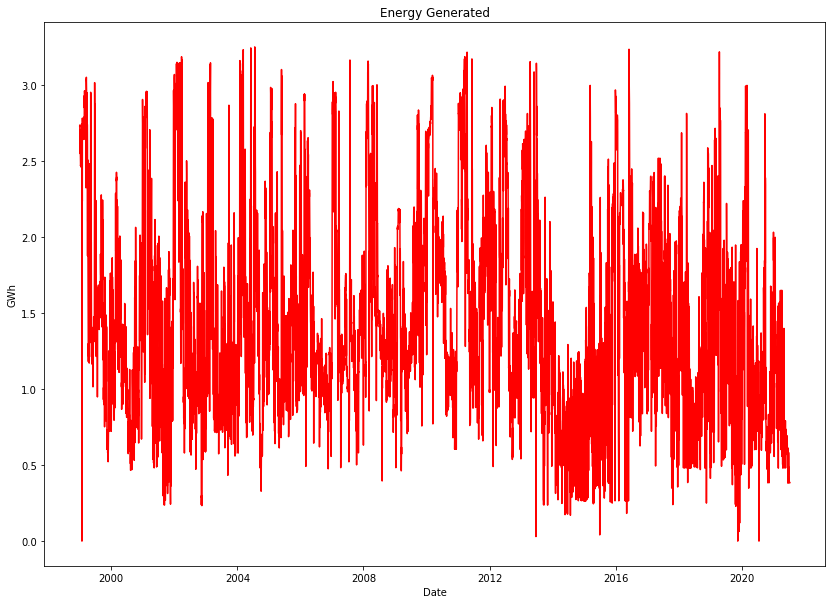

In [5]:
#plotting energy generated over full time period
plt.plot(df.date[:], df.energy_generated[:], 'r')   
plt.title('Energy Generated')
# Units not in GWh
plt.ylabel('GWh');
plt.xlabel('Date');
plt.show();

In the next cell we are doing the basic time series decomposition that was demonstrated in class

the results are not fruitful

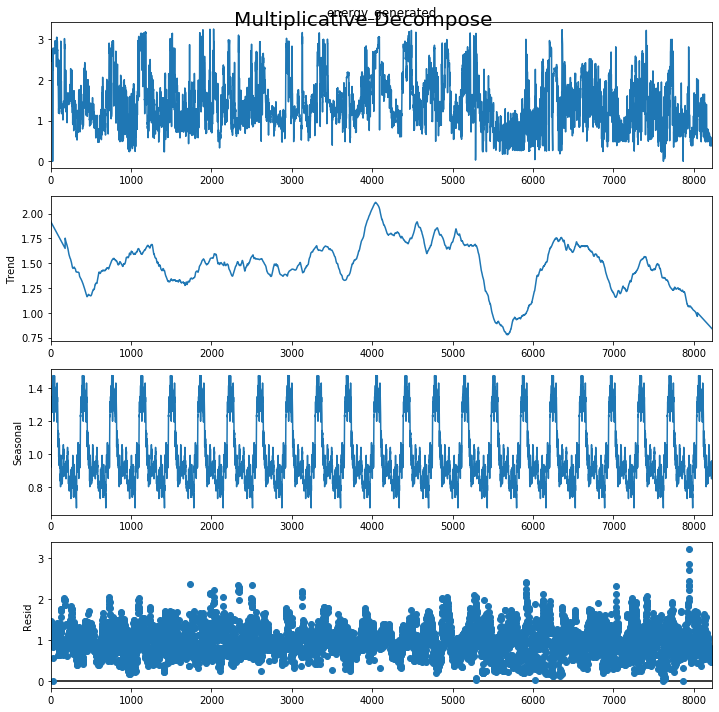

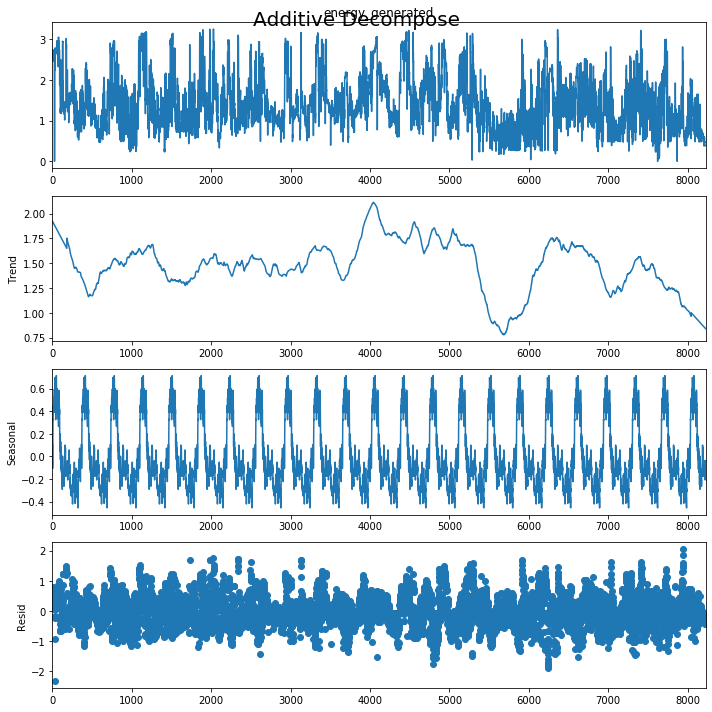

In [6]:


# Must choose a period for the decomposition; here choosing an annual one
# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
result_mul = seasonal_decompose(df['energy_generated'] + 0.0001, model='multiplicative', extrapolate_trend='freq', period=365)

# Additive Decomposition
result_add = seasonal_decompose(df['energy_generated'], model='additive', extrapolate_trend='freq', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)
plt.show()

Checking autocorrelation

In [19]:
num=int(len(df))
factors=[]
for i in range(1,num+1):
    if num%i==0:
       factors.append(i)

print ("Factors of {} = {}".format(num,factors))

Factors of 8228 = [1, 2, 4, 11, 17, 22, 34, 44, 68, 121, 187, 242, 374, 484, 748, 2057, 4114, 8228]


In [18]:
len(df)

4

In [20]:
#calculate autocorrelations
# nlags is how many lags to compute, presumably approximately evenly spaced
sm.tsa.acf(df['energy_generated'], nlags = 121)

array([ 1.        ,  0.86223697,  0.79042404,  0.75005731,  0.7120251 ,
        0.67781396,  0.66568687,  0.6776603 ,  0.60976593,  0.56740018,
        0.54629607,  0.53022956,  0.51753356,  0.51929838,  0.54341633,
        0.49684937,  0.46888431,  0.45779927,  0.4454274 ,  0.43638366,
        0.44405905,  0.46710721,  0.41971969,  0.39252541,  0.38046532,
        0.37015741,  0.36391043,  0.3740501 ,  0.40001022,  0.35818833,
        0.33680272,  0.33110715,  0.33154818,  0.32836861,  0.33858557,
        0.36579865,  0.32662368,  0.30675335,  0.30308873,  0.30104785,
        0.30036096,  0.31461467,  0.34522604,  0.308588  ,  0.28945689,
        0.28605769,  0.28222789,  0.27857836,  0.28972291,  0.31742112,
        0.27660096,  0.25741612,  0.25252601,  0.24977258,  0.24314614,
        0.25051781,  0.27497229,  0.23483463,  0.21196983,  0.20598822,
        0.20040583,  0.19361299,  0.19991515,  0.22303528,  0.18561606,
        0.16858707,  0.16427129,  0.15927835,  0.15206509,  0.15

From autocorrelation output above, we see that the autocorrelation is weak (just gets weaker and weaker as time goes back), and there doesn't seem to be any seasonality.  

The following code checks that lack of seasonality

In [21]:
asdf = sm.tsa.acf(df['energy_generated'], nlags = 121)

for n in range(len(asdf)):
    if n == 0:
        print('awer;jlkj')
    else: 
        if asdf[n] >= asdf[n-1]:
            print('increase correlation at', n)
            
            print(asdf[n])
            print(asdf[n-1])


awer;jlkj
increase correlation at 7
0.6776603036065417
0.6656868717554667
increase correlation at 13
0.5192983792781873
0.5175335641984374
increase correlation at 14
0.5434163269337411
0.5192983792781873
increase correlation at 20
0.44405904878339586
0.43638365568760445
increase correlation at 21
0.4671072050148518
0.44405904878339586
increase correlation at 27
0.37405010085017093
0.3639104250196374
increase correlation at 28
0.40001021933687525
0.37405010085017093
increase correlation at 32
0.3315481779973525
0.33110714649590345
increase correlation at 34
0.3385855741952977
0.3283686076232997
increase correlation at 35
0.36579865139636897
0.3385855741952977
increase correlation at 41
0.3146146652250436
0.3003609565704566
increase correlation at 42
0.3452260368808853
0.3146146652250436
increase correlation at 48
0.28972290508965937
0.2785783645578981
increase correlation at 49
0.317421116842218
0.28972290508965937
increase correlation at 55
0.2505178090241577
0.24314614162173656
increa

Maybe there is very slight seasonality, with period 7*121?  I should recheck the basic stuff with that kind of period

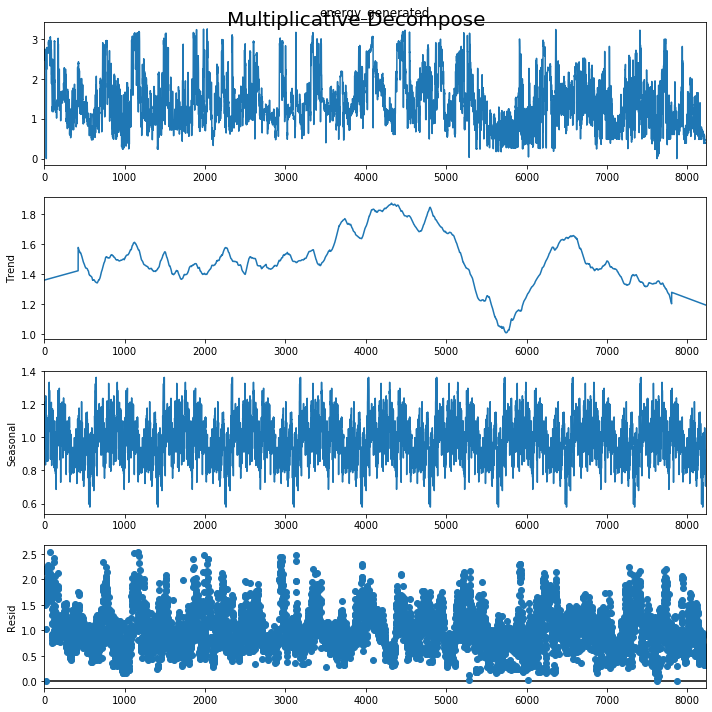

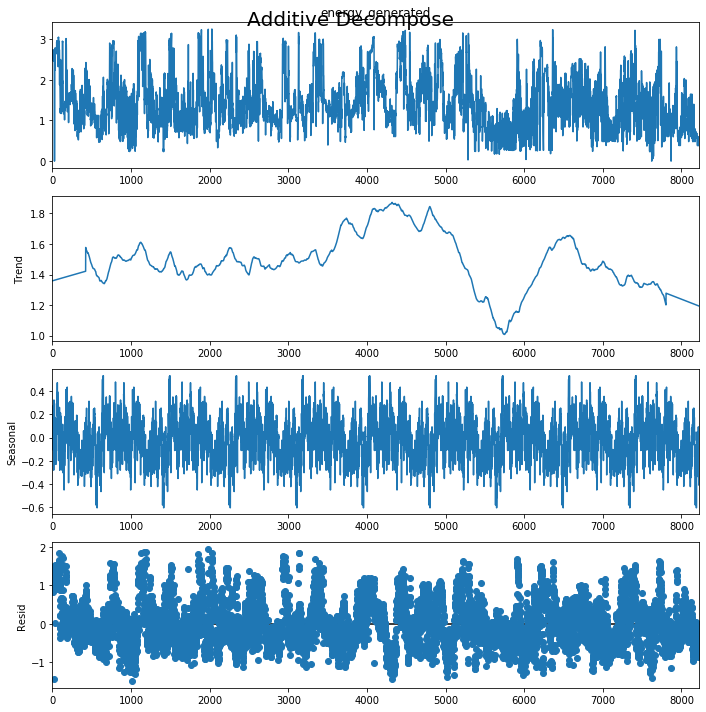

In [22]:
# Must choose a period for the decomposition; here choosing an annual one
# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
per = 7*121

result_mul = seasonal_decompose(df['energy_generated'] + 0.0001, model='multiplicative', extrapolate_trend='freq', period=per)

# Additive Decomposition
result_add = seasonal_decompose(df['energy_generated'], model='additive', extrapolate_trend='freq', period=per)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)
plt.show()

Didn't work any better really... but that's pretty expected

Let's do some windowing, and see if we can extract better patterns from smaller subsets

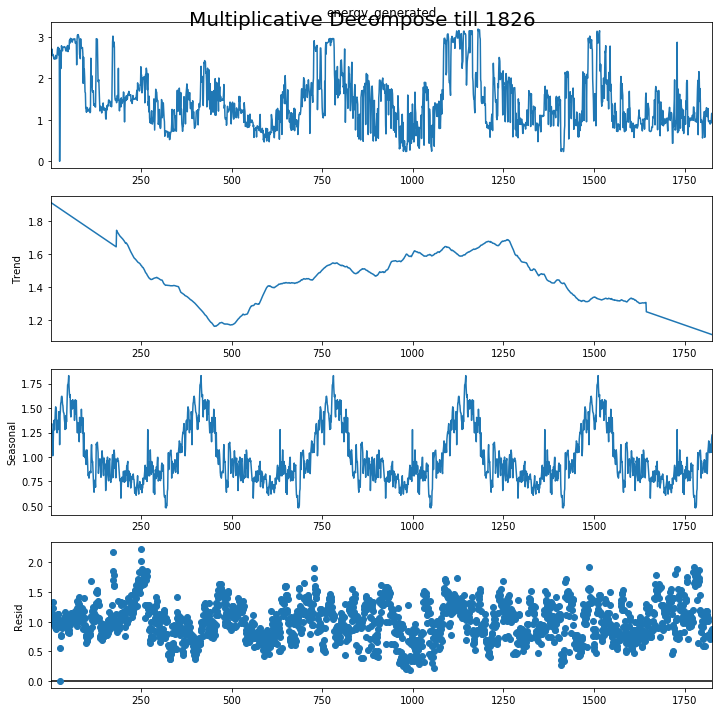

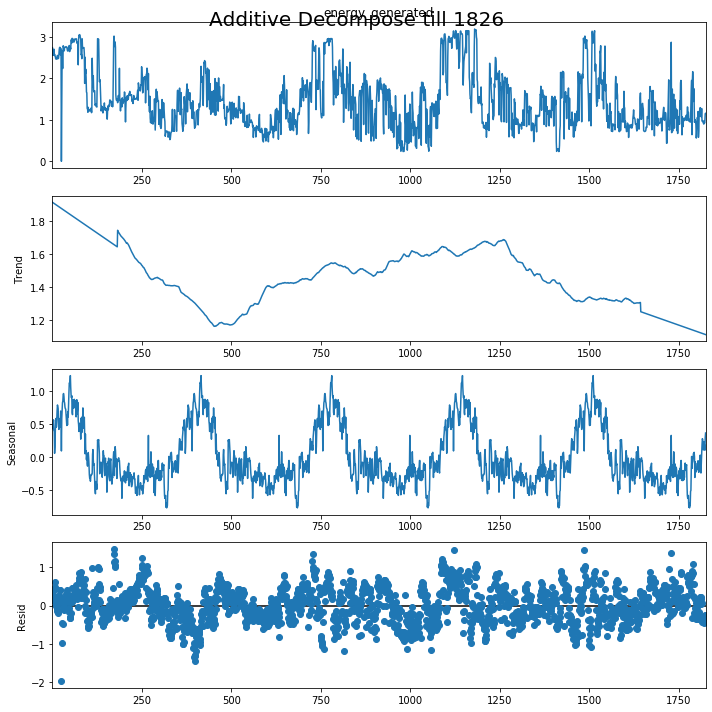

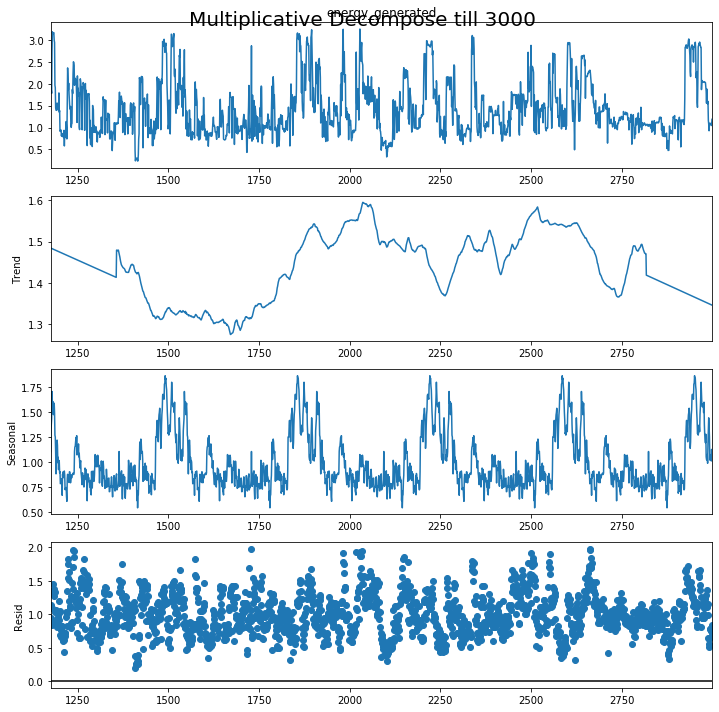

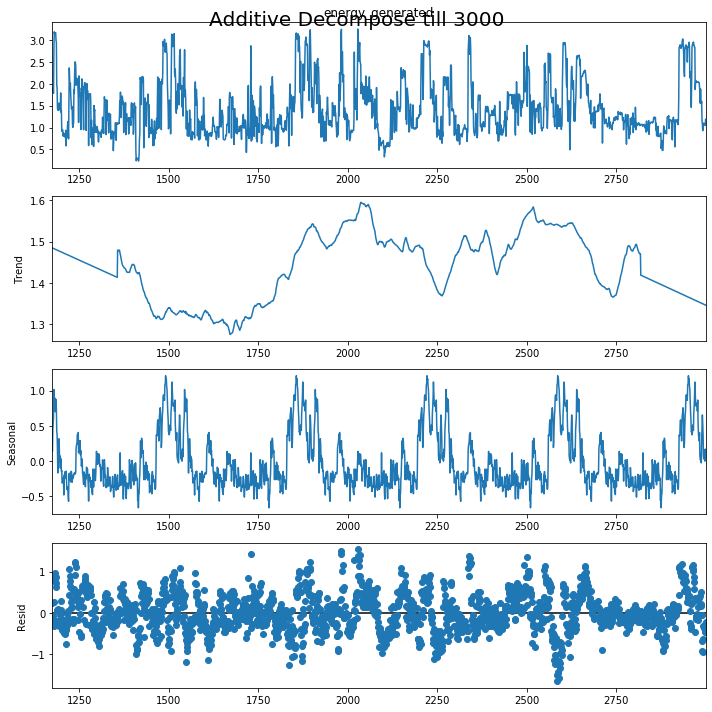

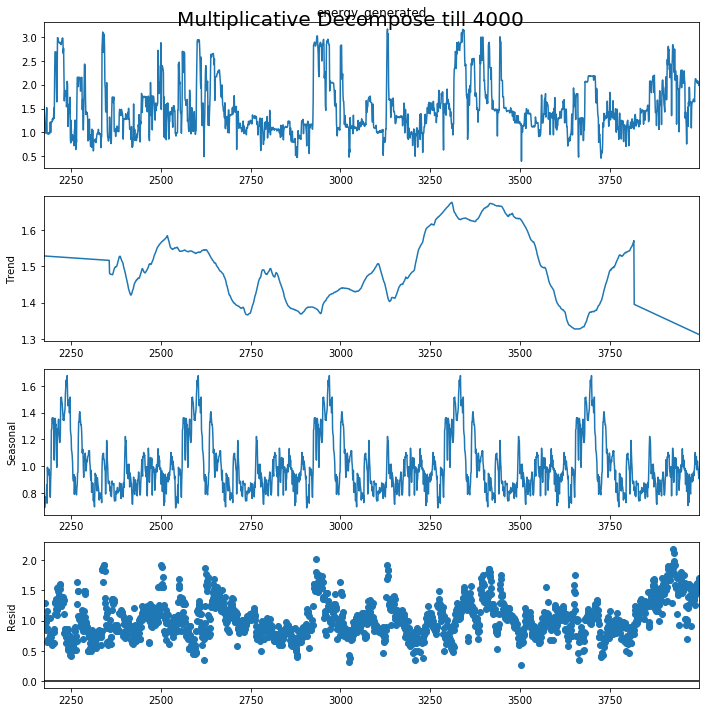

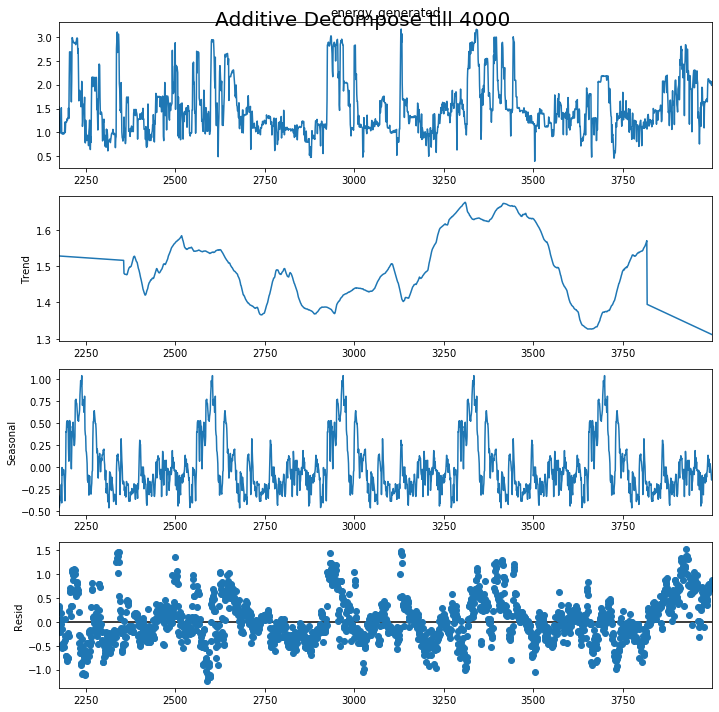

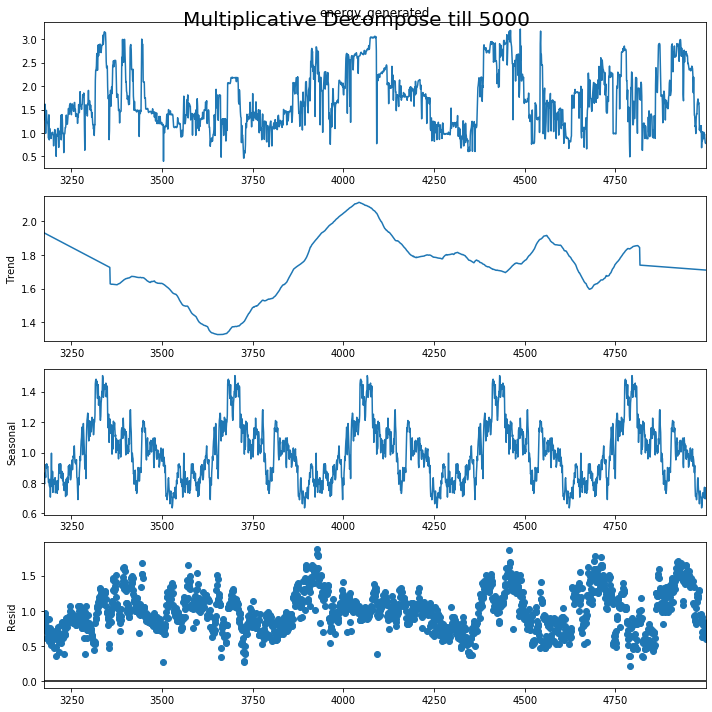

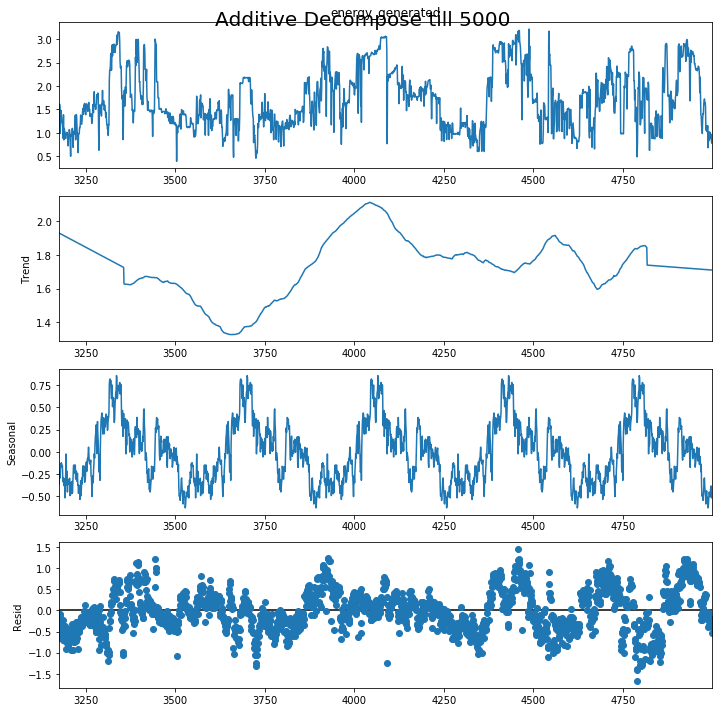

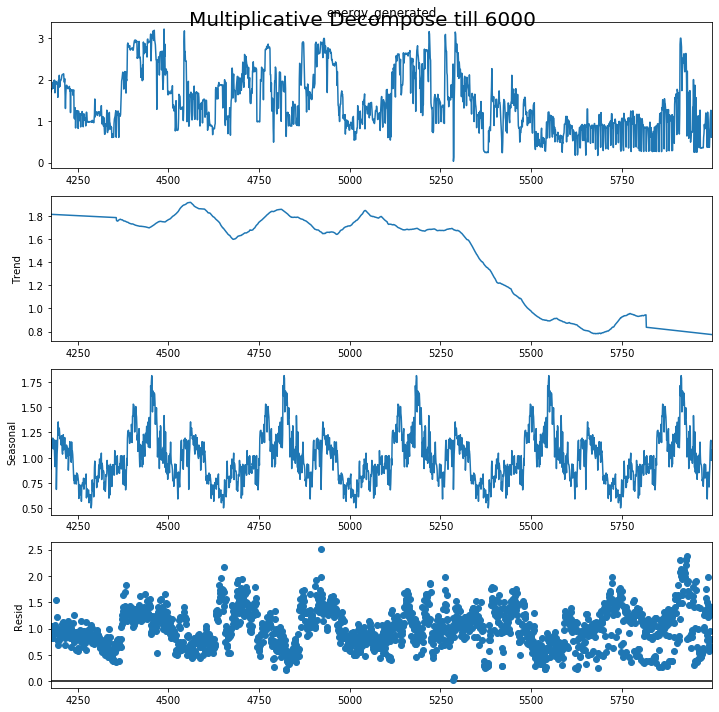

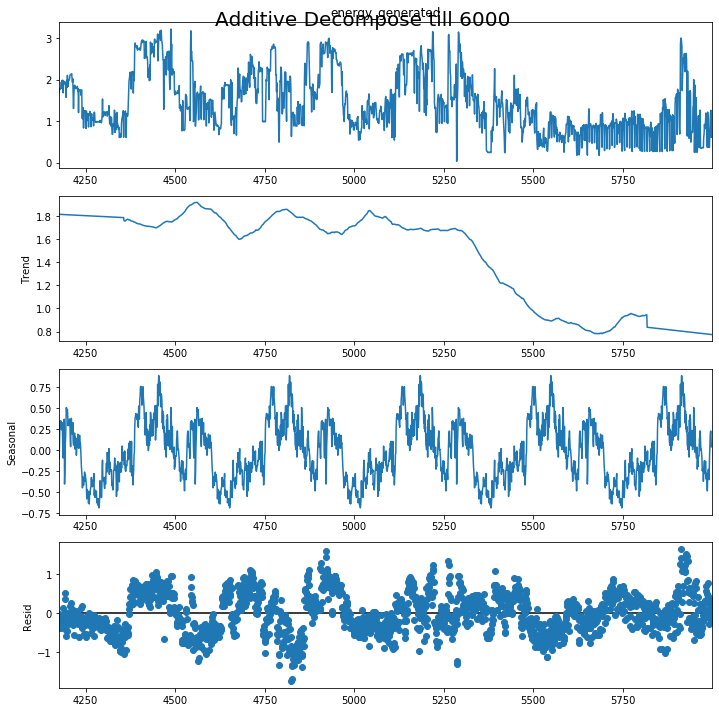

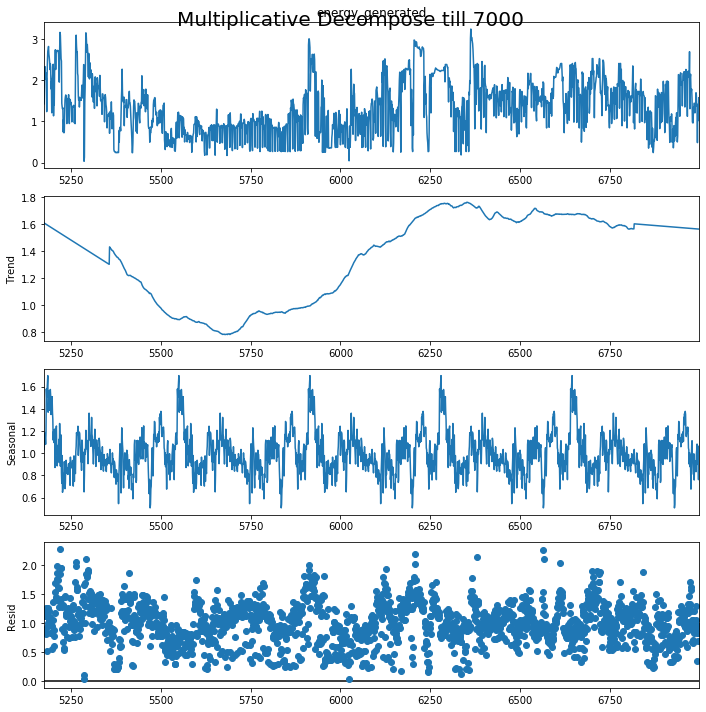

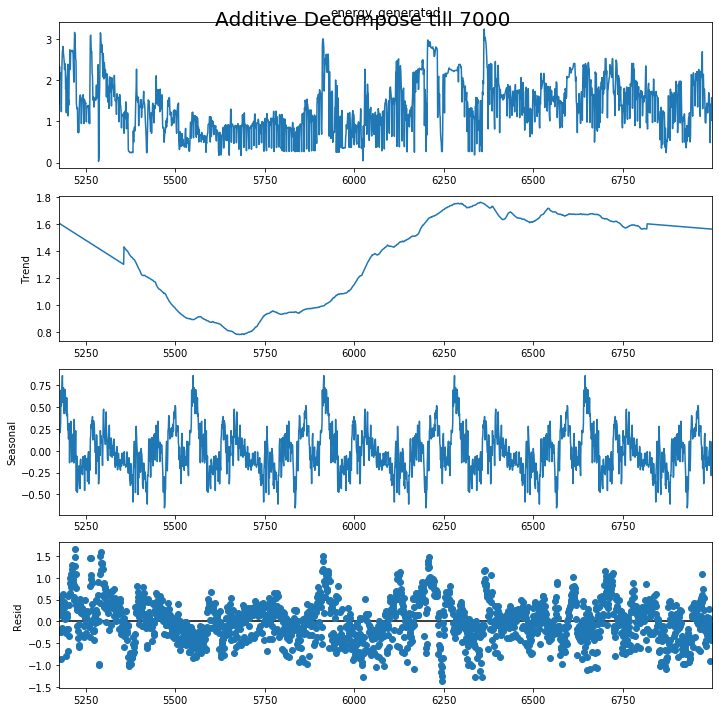

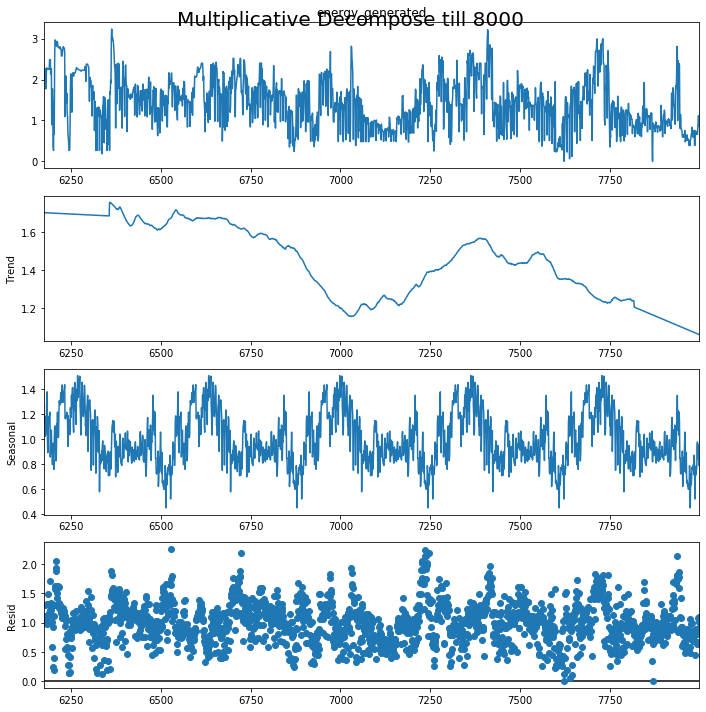

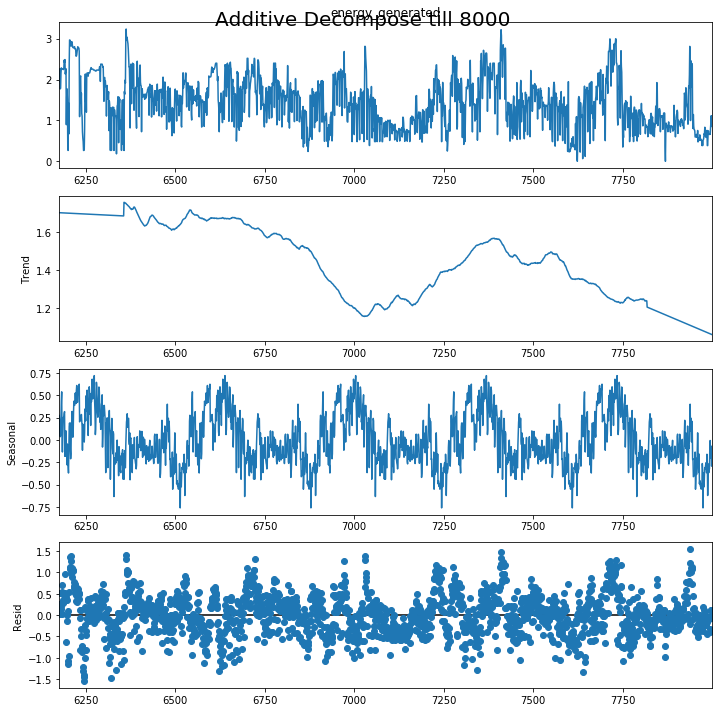

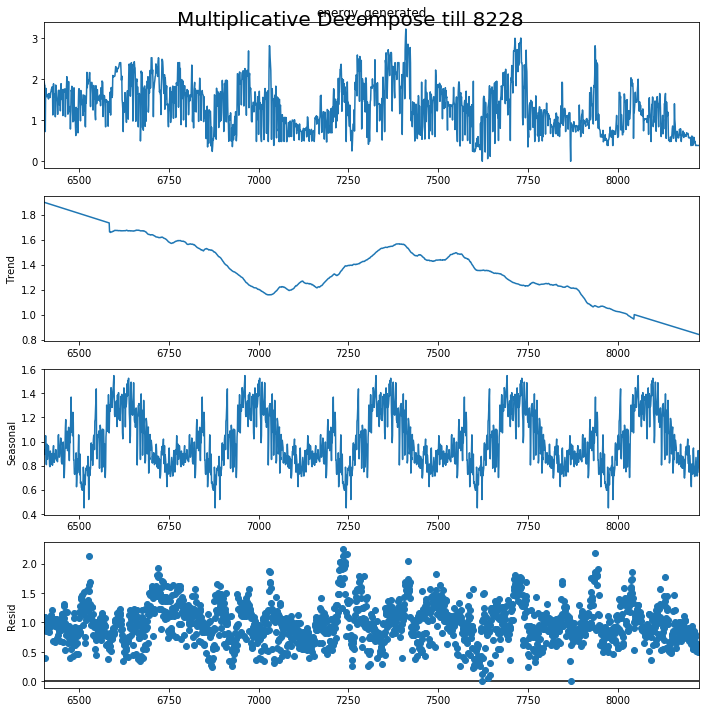

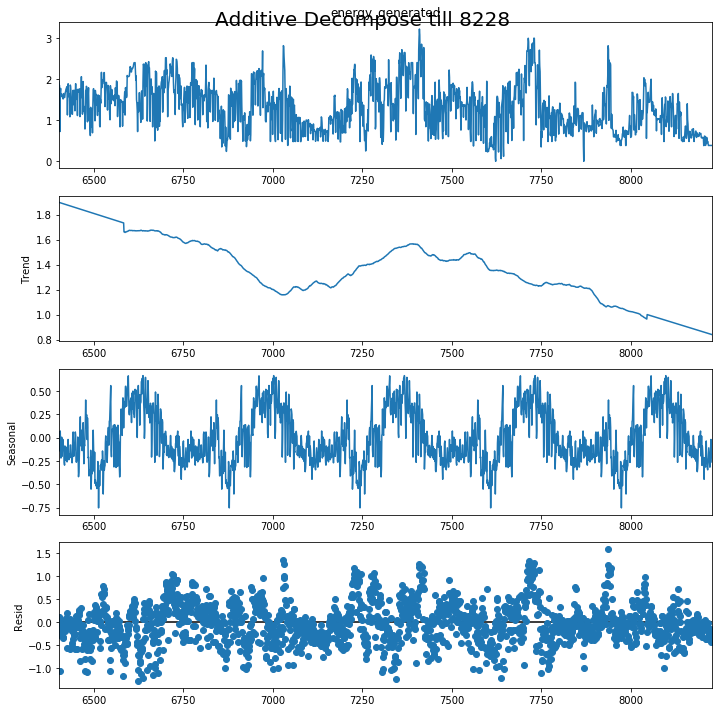

In [43]:
# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
#Choose periodicity of seasonality (currently 365 days naively)
per = 365
# how long of a window to examine over
win_length = 365*5
# ending point (should figure out how to put in dates here more directly at some point)
# these are pretty randomly chosen, should also see if I can pick some better windows by eye or by historical/weather events
end_points = [1826, 3000, 4000, 5000, 6000, 7000, 8000, len(df)]

for ends in end_points:
    
    result_mul = seasonal_decompose(df.iloc[(ends-win_length):ends,1] + 0.0001, model='multiplicative', extrapolate_trend='freq', period=per)

    # Additive Decomposition
    result_add = seasonal_decompose(df.iloc[(ends-win_length):ends,1], model='additive', extrapolate_trend='freq', period=per)

    # Plot
    plt.rcParams.update({'figure.figsize': (10,10)})
    result_mul.plot().suptitle('Multiplicative Decompose till %i' %ends, fontsize=20)
    result_add.plot().suptitle('Additive Decompose till %i' %ends, fontsize=20)
    plt.show()

In [42]:
365*5

1825